# A toy example of variational inference with normalizing flow (using the VI class)

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import optim

from matplotlib import pyplot as plt

batch_size = 128
epochs = 2000
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
from pixyz.distributions import CustomProb, Normal, TransformedDistribution
from pixyz.models import VI
from pixyz.flows import PlanarFlow, FlowList

In [3]:
def plot_samples(points):
    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_xlabel("p(z)")

    plt.show()

In [4]:
import torch
x_dim = 2

def log_prob(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    
    return -u

p = CustomProb(log_prob, var=["z"])

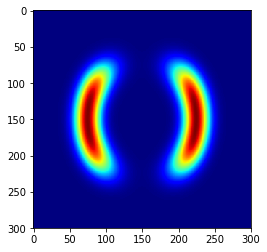

In [5]:
import numpy as np
def plot_density(p):

    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)

    density_values = p.prob().eval({"z":z}).data.numpy().reshape(shape)
    plt.imshow(density_values, cmap='jet')
    plt.show()
    
plot_density(p)

In [6]:
# prior
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["x"], dim=x_dim, name="prior")

In [7]:
# flow
f = FlowList([PlanarFlow(x_dim) for _ in range(32)])

In [8]:
# transformed distribution (x -> f -> z)
q = TransformedDistribution(prior, f, var=["z"], name="q")
q.to(device)

TransformedDistribution(
  (prior): Normal()
  (flow): FlowList(
    (0): PlanarFlow(in_features=2, constraint_u=False)
    (1): PlanarFlow(in_features=2, constraint_u=False)
    (2): PlanarFlow(in_features=2, constraint_u=False)
    (3): PlanarFlow(in_features=2, constraint_u=False)
    (4): PlanarFlow(in_features=2, constraint_u=False)
    (5): PlanarFlow(in_features=2, constraint_u=False)
    (6): PlanarFlow(in_features=2, constraint_u=False)
    (7): PlanarFlow(in_features=2, constraint_u=False)
    (8): PlanarFlow(in_features=2, constraint_u=False)
    (9): PlanarFlow(in_features=2, constraint_u=False)
    (10): PlanarFlow(in_features=2, constraint_u=False)
    (11): PlanarFlow(in_features=2, constraint_u=False)
    (12): PlanarFlow(in_features=2, constraint_u=False)
    (13): PlanarFlow(in_features=2, constraint_u=False)
    (14): PlanarFlow(in_features=2, constraint_u=False)
    (15): PlanarFlow(in_features=2, constraint_u=False)
    (16): PlanarFlow(in_features=2, constraint_u=

In [9]:
model = VI(p, q, optimizer=optim.Adam, optimizer_params={"lr":1e-2})
print(model)

Distributions (for training): 
  p(z), q(z) 
Loss function: 
  -(mean(E_q(z)[log p(z) - log q(z)])) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.01
      weight_decay: 0
  )


Epoch: 0 Test loss: 6.4803


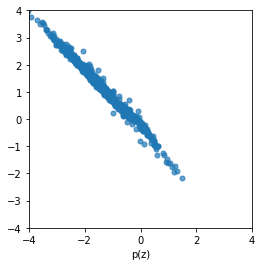

Epoch: 100 Test loss: -1.1877


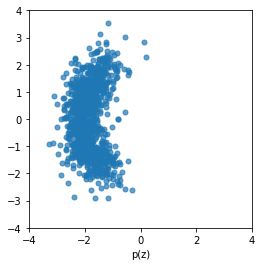

Epoch: 200 Test loss: -1.1466


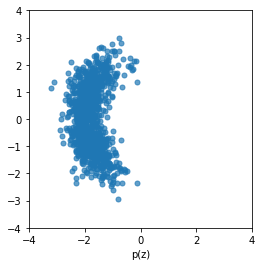

Epoch: 300 Test loss: -1.1645


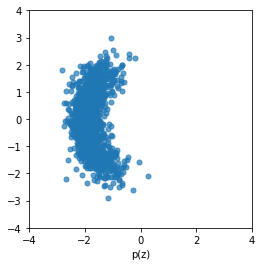

Epoch: 400 Test loss: -1.1888


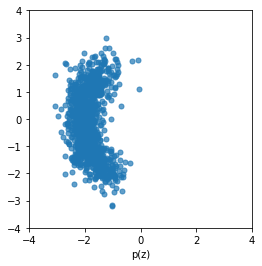

Epoch: 500 Test loss: -1.1708


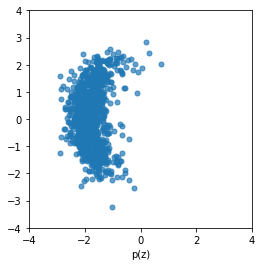

Epoch: 600 Test loss: -1.1336


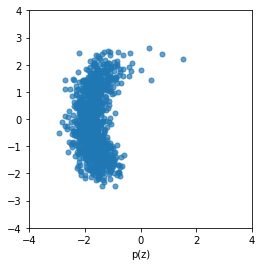

Epoch: 700 Test loss: -1.1495


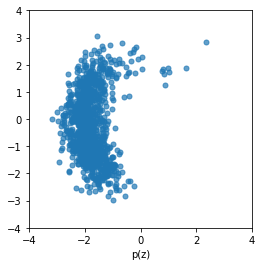

Epoch: 800 Test loss: -1.3017


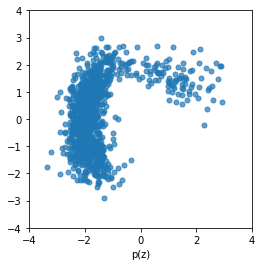

Epoch: 900 Test loss: -1.7738


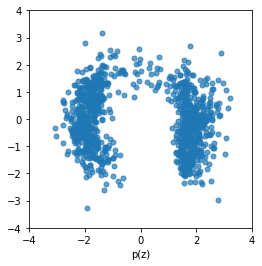

Epoch: 1000 Test loss: -1.8066


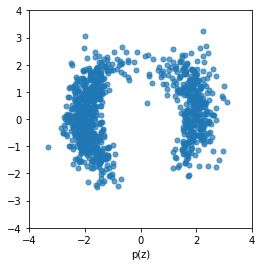

Epoch: 1100 Test loss: -1.7861


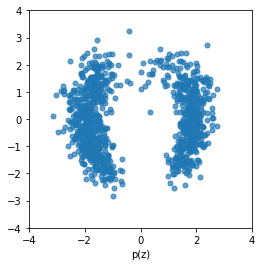

Epoch: 1200 Test loss: -1.8091


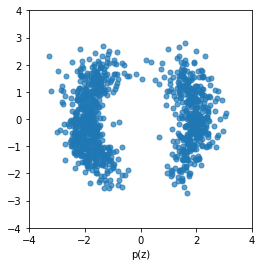

Epoch: 1300 Test loss: -1.8352


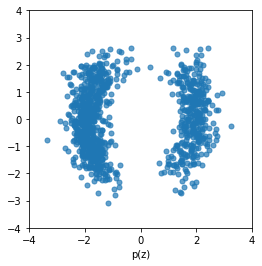

Epoch: 1400 Test loss: -1.7988


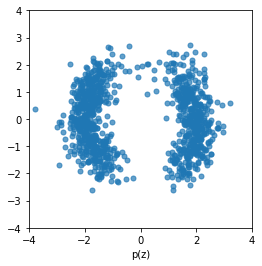

Epoch: 1500 Test loss: -1.8340


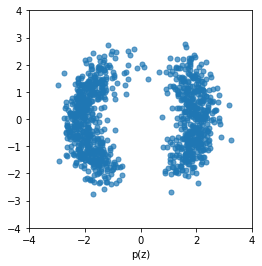

Epoch: 1600 Test loss: -1.7915


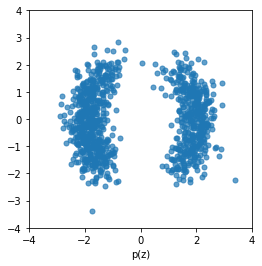

Epoch: 1700 Test loss: -1.8662


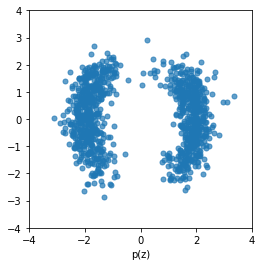

Epoch: 1800 Test loss: -1.8238


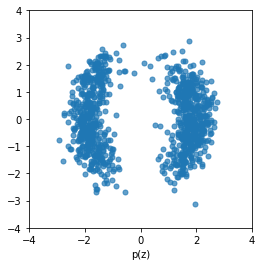

Epoch: 1900 Test loss: -1.8630


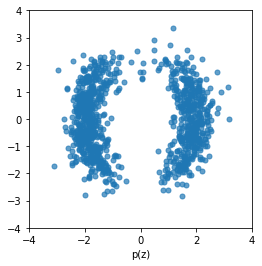

In [10]:
for epoch in range(epochs):
    loss = model.train(batch_size=batch_size)

    if epoch % 100 == 0:
        print('Epoch: {} Test loss: {:.4f}'.format(epoch, loss))
    
        loss = model.test(batch_size=batch_size)
        samples = q.sample(batch_size=1000)
        plot_samples(samples["z"].cpu().data.numpy())